# Named Entity Recognition using GMB(Groningen Meaning Bank) corpus

## Objective
Named Entity Recognition for annotated corpus using GMB(Groningen Meaning Bank) corpus for entity classification with enhanced and popular features by Natural Language Processing applied to the data set.

## Background

### Understanding Named Entity Recognition
Named Entity Recognition or Named Entity Recognition and Classification (NERC) is probably the first step towards information extraction that seeks to locate and classify named entities in text into pre-defined categories. Named entities are definite noun phrases that refer to specific types of individuals, such as organizations, persons, dates, and so on.
<br><br>
**Commonly Used Types of Named Entity:**

| NE Type      | Examples                                |
|--------------|-----------------------------------------|
| ORGANIZATION | Georgia-Pacific Corp., WHO              |
| PERSON       | Eddy Bonte, President Obama             |
| LOCATION     | Murray River, Mount Everest             |
| DATE         | June, 2008-06-29                        |
| TIME         | two fifty a m, 1:30 p.m.                |
| MONEY        | 175 million Canadian Dollars, GBP 10.40 |
| PERCENT      | twenty pct, 18.75 %                     |
| FACILITY     | Washington Monument, Stonehenge         |
| GPE          | South East Asia, Midlothian             |

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type. 
<br><br>
Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.
<br><br>
The IOB Tagging system contains tags of the form:<br>
**B** - {CHUNK_TYPE} – for the word in the Beginning chunk<br>
**I** - {CHUNK_TYPE} – for words Inside the chunk<br>
**O** – Outside any chunk<br>
<br>
The IOB tags are further classified into the following classes – 
<br>
**geo** = Geographical Entity<br>
**org** = Organization<br>
**per** = Person<br>
**gpe** = Geopolitical Entity<br>
**tim** = Time indicator<br>
**art** = Artifact<br>
**eve** = Event<br>
**nat** = Natural Phenomenon<br>

## Data source

The dataset an extract from GMB corpus which is tagged, annotated and built specifically to train the classifier to predict named entities such as name, location, etc. GMB is a fairly large corpus with a lot of annotations. Unfortunately, GMB is not perfect. It is not a gold standard corpus, meaning that it’s not completely human annotated and it’s not considered 100% correct. The corpus is created by using already existed annotators and then corrected by humans where needed.

## Analysis pipeline - the OSEMN approach

 - **Obtain the data** <br>
 The dataset is an extract of the GMB corpus which is tagged, annotated. It is in tab separated text file.
 - **Scrubbing / Cleaning the data** <br>
 Initial data exploration and preparation for analysis
 - **Exploring / Visualizing our data** <br>
 Basic EDA to understand the data
 - **Modeling the data** <br>
 Create classification models for NER
     -  Simple tree based model - RandomForest
     -  State of the art CRF model
     -  Hyperparameter tuning
 - **Interpreting the results** <br>
 Analysing the performance and further steps to improve

### Environment set-up and loading dependencies

Anaconda is used to do the analysis, which is an easy-to-install, free, enterprise-ready Python distribution for data analytics, processing, and scientific computing.
Dependencies used are below -

In [1]:
#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.grid_search import RandomizedSearchCV
import scipy.stats
import eli5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Obtain the data

In [2]:
data = pd.read_csv('GMB_dataset.txt', sep="\t", header=None, encoding="latin1")

## Scrubbing / Cleaning the data 

In [3]:
#Let us take a sneak-peak into the dataset first
data.head()

,0,1,2,3,4
0,NaN,Sentence #,Word,POS,Tag
1,0.0,1.0,Thousands,NNS,O
2,1.0,1.0,of,IN,O
3,2.0,1.0,demonstrators,NNS,O
4,3.0,1.0,have,VBP,O


In [4]:
#The dataset does not have any header currently. We can use the first row as a header as it has the relevant headings.
#We will make the first row as the heading, remove the first row and re-index the dataset
data.columns = data.iloc[0]
data = data[1:]
data.columns = ['Index','Sentence #','Word','POS','Tag']
data = data.reset_index(drop=True)
data.head()

,Index,Sentence #,Word,POS,Tag
0,0.0,1.0,Thousands,NNS,O
1,1.0,1.0,of,IN,O
2,2.0,1.0,demonstrators,NNS,O
3,3.0,1.0,have,VBP,O
4,4.0,1.0,marched,VBN,O


In [5]:
data.shape

(66161, 5)

In [6]:
#We have 66161 samples and 5 features. We will understand them in detail in the exploration step.
#Lets check for any missing values in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66161 entries, 0 to 66160
Data columns (total 5 columns):
Index         66161 non-null float64
Sentence #    66161 non-null object
Word          66161 non-null object
POS           66161 non-null object
Tag           66161 non-null object
dtypes: float64(1), object(4)
memory usage: 2.5+ MB


*Seems the dataset does not contain any missing values, and we are good to proceed to the exploration step where we will try to understand the data more.*

## Exploring / Visualizing our data

*Before going further, we will try to understand what the dataset is all about and what all the features mean. This is important in order to understand how the classifiers will perform and help us interpret the results.*

In [8]:
data.head()

,Index,Sentence #,Word,POS,Tag
0,0.0,1.0,Thousands,NNS,O
1,1.0,1.0,of,IN,O
2,2.0,1.0,demonstrators,NNS,O
3,3.0,1.0,have,VBP,O
4,4.0,1.0,marched,VBN,O


The dataset has the following columns or features - <br>
 - **Index** - Index numbers for each word [Numeric type]
 - **Sentence #** - The number of sentences in the dataset (We will find the number of sentences below) [Numeric type]
 - **Word** - The words in the sentence [Character type]
 - **POS** - Parts Of Speech tags, these are tags given to the type of words as per the Penn TreeBank Tagset [Categorical type]
 - **Tag** - The tags given to each word based on the IOB tagging system described above (Target variable) [Categorical type]

*Since the dataset is annotated with POS and Tags, we will build a simple class to combine the words into a sentence. This will help us understand the extract of the dataset.*

In [13]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [15]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [16]:
#Lets find the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

8766


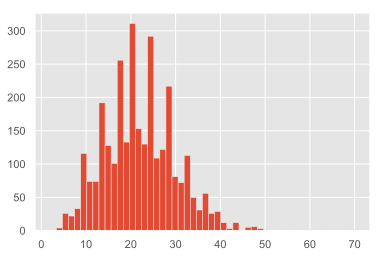

In [17]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

*It seems most of the sentences are 20-30 words long, and the distribution is normal.*

In [18]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 70


*Now that we know the words and sentences, lets try to understand what sort of words each tag contains. This will help us in understanding what each tag type and sub-type represents.*

In [26]:
#Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

In [27]:
#Words tagged as I-org
data.loc[data['Tag'] == 'I-org', 'Word'].head()

98      Party
155    Atomic
156    Energy
157    Agency
235     Union
Name: Word, dtype: object

In [28]:
#Words tagged as B-per
data.loc[data['Tag'] == 'B-per', 'Word'].head()

42          Bush
270    President
331       Thomas
443    President
965      Prophet
Name: Word, dtype: object

In [29]:
#Words tagged as I-per
data.loc[data['Tag'] == 'I-per', 'Word'].head()

271        Mahmoud
272    Ahmadinejad
332        Horbach
444      Abdullahi
445          Yusuf
Name: Word, dtype: object

In [30]:
#Words tagged as B-geo
data.loc[data['Tag'] == 'B-geo', 'Word'].head()

6        London
12         Iraq
65         Hyde
94      Britain
106    Brighton
Name: Word, dtype: object

In [31]:
#Words tagged as I-geo
data.loc[data['Tag'] == 'I-geo', 'Word'].head()

66      Park
347    State
350    State
381    Delta
561     Arab
Name: Word, dtype: object

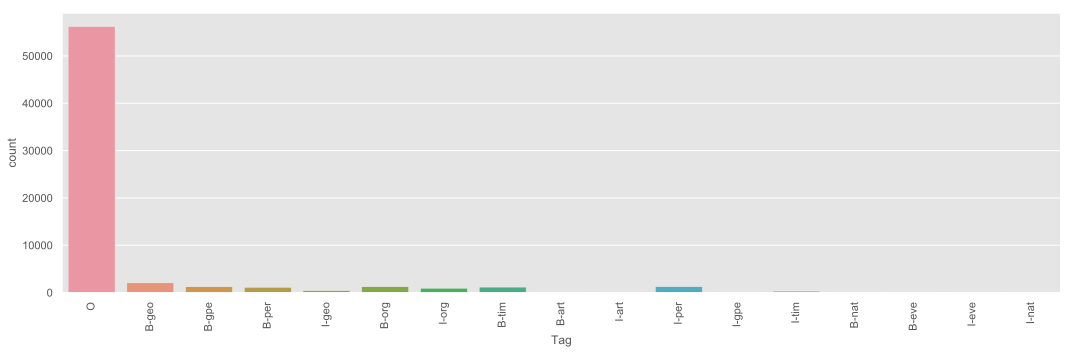

In [19]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

*Quite surprising, most of the words are tagged as outside of any chunk. These words can be considered as fillers and their presence might impact the classifier performance as well. Lets check the dataset again without the O tags.*

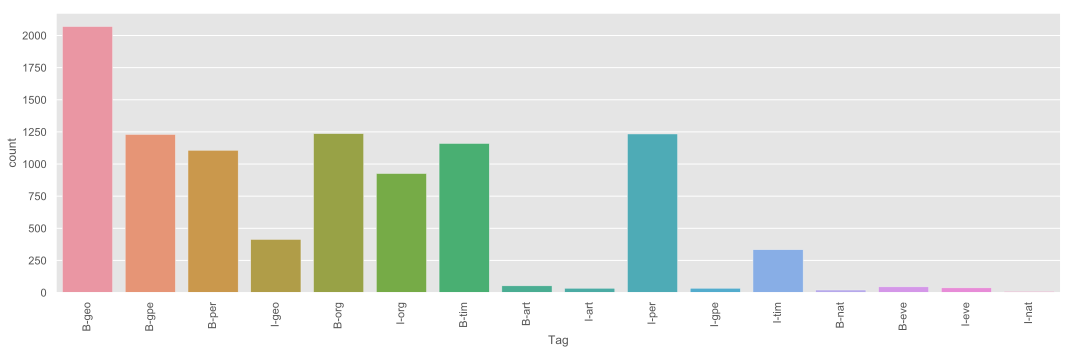

In [24]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

*So our dataset mostly contains words related to geographical locations, geopolitical entities and person names.*

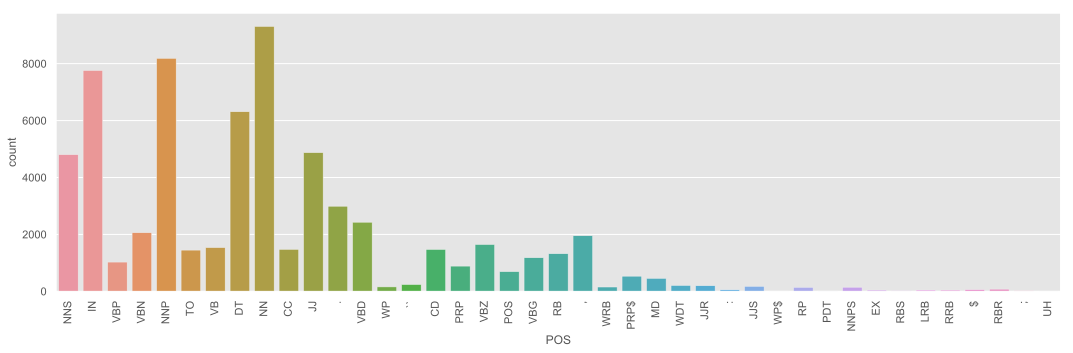

In [25]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Modeling the data
With the basic EDA done and understanding the dataset, we can move to the modeling stage. <br>
Since the problem statement is a simple classification problem, we will start with a simple tree based model, Random Forest using a simple feature map. <br>
Simple tree based models have been proven to provide decent performance in building NERC systems. Random Forest being one of the most popular tree based models can learn the underlying rules according to which terms are tagged. It is important that the classifier has proper features fed in to improve the performance. 
<br> <br>
We chose Random Forest because of the following reasons - <br>
Firstly, RF is able to automatically construct correlation paths from the feature space, i.e. decision rules that correspond to the translation rules that we intend to capture. <br>
Secondly, RF is considered one of the most accurate classifier available.

### Performance metrics

Before we move to the modeling part, it is important to understand the performance metrics on the basis of which the models will be evaluated. Since we are dealing with Information Extraction, we will use the following metrics to evaluate the models - <br>
 - **Precision**
 - **Recall**
 - **F1 score**
<br> <br>
The metrics mentioned above are calculated using True/False positives and True/False negatives respectively. <br>
 - **True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
 - **True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
 - **False Positives (FP)** – When actual class is no and predicted class is yes. 
 - **False Negatives (FN)** – When actual class is yes but predicted class in no. 
 - **Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. <br> <br>
 $ Precision = TP/TP+FP $
 <br> <br>
 - **Recall (Sensitivity)** - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. <br><br>
 $ Recall = TP/TP+FN $
 <br><br>
 - **F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is the harmonic mean of the both Precision and Recall <br><br>
 $ \begin{equation*}
 F1-Score = 2*\frac{(Recall * Precision)}{(Recall + Precision)}
 \end{equation*}
 $
 <br><br>
For a decent classifier, we would prefer high precision and recall values. Classification reports are used to obtain the values of these metrics in a text format per class. It is essential that the model is evaluated by these metrics per class to make sure we have a good model.


*Now we shall start with the modeling part where we create new features, create the model and evaluate it on the metrics stated above.*

### Random Forest classifier

In [32]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [33]:
#We divide the dataset into train and test sets
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [38]:
#Lets see how the input array looks like
print(words[:5])

[array([1, 0, 0, 9, 0, 1]), array([0, 1, 0, 2, 0, 1]), array([ 0,  1,  0, 13,  0,  1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 7, 0, 1])]


*We will use 5 fold cross validation as an input parameter to the classifier, i.e. we will divide the dataset into 5 subsets and train-test on them. Some models like decision trees and neural networks are often be able to get 100% accuracy on the training data, but perform much worse on new data. Therefore, we will train on one subset and test on the other, and repeat for every subset so that the classifier classifies correctly on average and the performance estimate is not overly optimistic.*

In [39]:
#Random Forest classifier
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [40]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00        53
      B-eve       0.00      0.00      0.00        45
      B-geo       0.23      0.71      0.35      2070
      B-gpe       0.18      0.14      0.16      1230
      B-nat       0.00      0.00      0.00        20
      B-org       0.62      0.16      0.25      1237
      B-per       0.98      0.19      0.32      1107
      B-tim       0.28      0.33      0.31      1160
      I-art       0.00      0.00      0.00        34
      I-eve       0.00      0.00      0.00        37
      I-geo       0.00      0.00      0.00       414
      I-gpe       0.00      0.00      0.00        34
      I-nat       0.00      0.00      0.00         9
      I-org       0.36      0.02      0.05       926
      I-per       0.31      0.01      0.02      1234
      I-tim       0.47      0.05      0.09       334
          O       0.97      0.98      0.98     56217

avg / total       0.88      0.87      0.86  

*Although we have a good average score, the model performed quite badly. The precision and recall values of most of the classes were 0. It seems the features which require the model to take proper decisions are missing. The model is basically memorizing words and tags, which will not suffice. The context information behind each word needs to be fed to the model as well so that the predictions are more accurate. <br>
We can either work on this model alone by improving the features or ensembling it with a more contextual model, or use a different model altogether.*

### Conditional Random Fields classifier

A Conditional Random Field (CRF) is a standard model for predicting the most likely sequence of labels that correspond to a sequence of inputs. It is a supervised learning method which has been proven to be better than the tree based models when it comes to NER. Whereas a discrete classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account; e.g., the linear chain CRF (which is popular in natural language processing) predicts sequences of labels for sequences of input samples. <br>
We will be using the LGBFS algorithm (Gradient descent using the L-BFGS method) and it works best using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. Gradient Descent will be used as an optimization function.

*In order to use CRF, we will enhance the feature set and create more features which can be used by the model to predict the tags correctly. Since we need to take into account the context as well, we create features which will provide consecutive POS tags for each word. Also, we add new features such as upper, lower, digit, title etc. for each word and also consider the consecutive words in the list. In short, we try to provide a sequence of features to the model for each word - the sequence containing POS tags, capitalisations, type of word(title) etc.*

In [41]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [42]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [48]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [49]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [50]:
#We predcit using the same 5 fold cross validation
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

In [51]:
#Lets evaluate the mode
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

             precision    recall  f1-score   support

      B-art       0.14      0.02      0.03        53
      B-eve       0.52      0.27      0.35        45
      B-geo       0.72      0.83      0.77      2070
      B-gpe       0.84      0.75      0.79      1230
      B-nat       0.50      0.20      0.29        20
      B-org       0.67      0.59      0.63      1237
      B-per       0.79      0.77      0.78      1107
      B-tim       0.89      0.81      0.85      1160
      I-art       0.00      0.00      0.00        34
      I-eve       0.53      0.22      0.31        37
      I-geo       0.67      0.62      0.64       414
      I-gpe       0.23      0.09      0.13        34
      I-nat       1.00      0.33      0.50         9
      I-org       0.71      0.71      0.71       926
      I-per       0.81      0.90      0.86      1234
      I-tim       0.75      0.57      0.65       334
          O       0.99      0.99      0.99     56217

avg / total       0.95      0.96      0.95  

*Compared to the Random Forest classifier, the CRF classifier did better as the scores have improved. However, the precision and recall metrics of the classes individually have not improved. Maybe the model is again remembering words and not taking into the context information completely. We will try tuning the model manually to see if we can improve it.*

In [52]:
#Tuning the parameters manually, setting c1 = 10
crf2 = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [53]:
pred = cross_val_predict(estimator=crf2, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00        53
      B-eve       0.00      0.00      0.00        45
      B-geo       0.62      0.86      0.72      2070
      B-gpe       0.85      0.69      0.76      1230
      B-nat       0.00      0.00      0.00        20
      B-org       0.64      0.47      0.54      1237
      B-per       0.74      0.74      0.74      1107
      B-tim       0.93      0.67      0.78      1160
      I-art       0.00      0.00      0.00        34
      I-eve       0.00      0.00      0.00        37
      I-geo       0.60      0.44      0.51       414
      I-gpe       0.00      0.00      0.00        34
      I-nat       0.00      0.00      0.00         9
      I-org       0.62      0.60      0.61       926
      I-per       0.74      0.90      0.81      1234
      I-tim       0.76      0.40      0.52       334
          O       0.99      0.99      0.99     56217

avg / total       0.94      0.95      0.94  

In [65]:
crf2.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=10, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

*The average score has dropped but the individual precision and recall scores have improved. The model is trying to understand the context as well and not just remember words. We can see that there is a scope of improving the model. Maybe we can do it computationally and get a better model.*

### Hyperparameter tuning using Randomized CV Search

In [60]:
#First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(crf.classes_)
labels = list(filter(lambda a: a != 'O', labels))
print(labels)

['B-geo', 'B-gpe', 'B-tim', 'B-org', 'I-geo', 'B-per', 'I-per', 'I-org', 'B-nat', 'I-tim', 'I-gpe', 'I-nat', 'B-art', 'I-art', 'B-eve', 'I-eve']


In [66]:
%%time
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf3 = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.9min finished


Wall time: 19min 15s


In [67]:
#Lets check the best estimated parameters and CV score
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.15671439778885257, 'c2': 0.067901461235833765}
Best CV score: 0.7469393682243498
Model size: 0.58M


In [68]:
#We sort the tags a bit so that they appear in an orderly fashion in the classification report
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

In [69]:
#Now we create the model again using the best estimators
crf3 = rs.best_estimator_
y_pred = crf3.predict(X)
print(metrics.flat_classification_report(
    y, y_pred, labels=sorted_labels, digits=3))

             precision    recall  f1-score   support

      B-art      0.981     0.981     0.981        53
      I-art      1.000     1.000     1.000        34
      B-eve      1.000     1.000     1.000        45
      I-eve      1.000     1.000     1.000        37
      B-geo      0.903     0.971     0.936      2070
      I-geo      0.923     0.952     0.937       414
      B-gpe      0.963     0.900     0.931      1230
      I-gpe      0.952     0.588     0.727        34
      B-nat      1.000     0.850     0.919        20
      I-nat      1.000     1.000     1.000         9
      B-org      0.969     0.888     0.927      1237
      I-org      0.984     0.978     0.981       926
      B-per      0.976     0.976     0.976      1107
      I-per      0.976     0.990     0.983      1234
      B-tim      0.988     0.959     0.973      1160
      I-tim      0.988     0.967     0.977       334

avg / total      0.959     0.952     0.955      9944



*Now we have a good model with decent precision and recall scores for each class. We can fit this model and use it to predict tags given a sentence.*

In [70]:
crf3.fit(X,y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None,
  c1=0.15671439778885257, c2=0.067901461235833765,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

*Now since we have good model, we can take sneak peek into the model and see how it is classifying and what all weights are assigned. ELI5 report has built-in support for several ML frameworks and provides a way to explain black-box models.*

In [71]:
eli5.show_weights(crf3, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.517,1.088,-2.045,1.245,-1.574,1.229,-3.909,0.199,-1.507,0.133,-0.94,1.427,-5.087,1.997,-3.494,1.292,-5.022
B-art,0.129,0.0,6.418,0.0,0.0,0.0,0.0,-0.011,0.0,0.0,0.0,0.0,-0.402,-0.763,-0.151,0.0,0.0
I-art,-0.459,0.0,5.9,0.0,0.0,0.792,0.0,0.0,0.0,0.0,0.0,0.0,-0.02,-0.328,-0.101,0.0,0.0
B-eve,-0.436,0.0,0.0,0.0,5.823,0.0,0.0,-0.344,0.0,0.0,0.0,0.0,-0.389,-0.329,-0.042,0.0,-0.205
I-eve,-0.008,0.0,0.0,-1.001,4.887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0
B-geo,0.702,1.201,-0.512,0.0,-0.207,-1.22,6.571,0.972,-1.143,0.0,0.0,-1.194,-1.925,-2.229,-1.99,1.512,-1.412
I-geo,0.058,0.0,0.0,0.0,0.0,-0.375,5.58,-0.165,-1.024,0.0,0.0,-0.218,-1.148,-1.172,-0.717,0.0,-1.145
B-gpe,0.684,0.0,-0.458,0.0,-0.242,-0.446,-1.603,-4.093,4.806,0.0,0.0,1.48,-2.393,0.358,-1.56,-1.963,-1.458
I-gpe,-0.269,0.0,0.0,0.0,0.0,0.136,0.0,-0.132,4.973,0.0,0.0,0.0,-0.087,0.0,-0.0,0.0,0.0
B-nat,-0.301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.511,0.0,0.0,-0.042,0.0,0.0,0.0


## Interpreting the results

*Let's try to understand the report in brief. <br>
CRFsuite CRF models use two kinds of features: state features and transition features. <br>
Transition features make sense: at least model learned that **I-ENITITY** must follow **B-ENTITY**. It also learned that some transitions are unlikely, e.g. it is not common in this dataset to have a location right after an organization name, i.e. **I-ORG** -> **B-LOC** has a negative weight.
We can expect that **O** -> **I-ENTITY** transitions to have large negative weights because they are impossible. <br>
We can also see that **B-ORG** -> **I-ORG** has positive weights which makes sense, as the First names are always followed by the inner names, the same applies for organisations.*

Now we have a good model fit using the CRF classifier. The model is not perfect and it can be further improved by various ways -<br>
 - Adding more features to the model e.g. combination of words with gives a proper meaning - e.g. President Obama, Park Street etc.
 - Using a larger corpus from the GMB dataset.
 - Current implementation considers only 2 hyper parameters in CV search, however, the CRF model offers more parameters which can be further tuned to improve on the performance. 
 - Using a LSTM neural network and creating a ensemble model with CRF. Since NER usually deals with a huge corpus, neural networks are very efficient in identifying patterns in the data provide a better model.
 - Using state of the art deep learning models using Keras or Tensor Flow - deep learning models are known to outperform every other model when it comes to huge datasets, therefore they can be used to create a superior NER classifier.
 - Using different algorithms in the CRF model. Currently it uses Gradient Descent but Stochastic Gradient Descent can be used to create a faster model. 
<br> <br>
It is possible to improve the model performance from a current 95% F1-score to about 98% using the above techniques. It requires huge computing resources to achieve this performance boost, unfortunately. 


## References -
 - SKLearn CRF Documentation - https://sklearn-crfsuite.readthedocs.io/en/latest/index.html
 - ELI5 report documentation - https://media.readthedocs.org/pdf/eli5/0.4/eli5.pdf
 - POS tagging and NER - https://hpi.de/fileadmin/user_upload/fachgebiete/plattner/teaching/NaturalLanguageProcessing/NLP2015/NLP04_POS_NER.pdf
 - Survey of different NER techniques - https://nlp.cs.nyu.edu/sekine/papers/li07.pdf
 - NLTK book chapter 7 - http://www.nltk.org/book/ch07.html
 - Annotated GMB corpus dataset - https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/home
 - Understanding Model performance - https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/